# EMD comparisons for SIGNAL-seq ADT and CyTOF data

In [1]:
# Load packages
import anndata as ad
import scanpy as sc
import muon as mu
import seaborn as sns
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import numpy as np
import scipy.stats as stats
import sys, os, argparse

# Import utils
# Get the current working directory
current_dir = os.getcwd()
utils_path = os.path.join(current_dir, '../../', 'utils')
sys.path.append(utils_path)


# Import adt utils functions
from adt_utils import calculate_emd

In [2]:
# Setup the global plotting parameters
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.set_figure_params(dpi=100, color_map = 'viridis', frameon=True, transparent=True,
                    dpi_save=800, facecolor='None', format='pdf', figsize=[5,5])

# Figure output directory
sc.settings.figdir = 'emd_figures'

# Colour map
# Fill in the clusters that belong to each cell type based on each marker in the plot above
colour_dict = {'Control': 'tab:blue', 
               'EGF IGF1': 'tab:green', 
               'GFs MEKi PI3Ki': 'tab:red'}

scanpy==1.9.6 anndata==0.10.4 umap==0.5.5 numpy==1.26.3 scipy==1.12.0 pandas==2.2.0 scikit-learn==1.4.0 statsmodels==0.14.1 igraph==0.10.4 pynndescent==0.5.11


## Import data objects

In [3]:
# File path - Also load Muon object
fp_mdata = '../02_preprocessing_multimodal/2023_03_30_mdata_01.h5mu'

# Load the Muon SIGNAL-seq object
mdata = mu.read(fp_mdata)

mdata

/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(
/opt/miniconda3/envs/scanpy_v1/lib/python3.10/site-packages/anndata/_core/anndata.py:522: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


MuData object with n_obs × n_vars = 1143 × 29260
  var:	'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells'
  2 modalities
    rna:	1143 x 29237
      obs:	'sub_lib_id', 'sum', 'detected', 'total', 'sample_id', 'well_indexes', 'barcode_seq', 'mapped_reads', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_lnc', 'pct_counts_lnc', 'log10_total_counts', 'umi_rds_ratio', 'outlier_total', 'outlier_ngenes', 'lowq_counts', 'lowq_mt', 'outlier_rds', 'n_genes', 'S_score', 'G2M_score', 'phase', 'Amit_Nat_Gen_2007', 'pP120-Catenin_[T310]', 'pRB_[S807/811]_v1', 'cCaspase_3_[D175]_v2', 'pPDPK1_[S241]', 'pMKK4/SEK1_[S257]', 'pBTK_[Y551]_1_v2', 'p4E-BP1_[T37/46]_v2', 'pAKT_[T308]', 'pNF-κB_p65_[S529]', 'pP38_MAPK_[T180/Y182]_v2', 'pS6_[S240/S244]_2', 'CK18', 'Cyclin_B1_2', 'pNDRG1_[T346]', 'me2_Histone_H3_[K4]'
      var:	'gene_ids', 'lnc', 'lncipediaGeneID', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
      uns:	'X_name', 'hvg', 'library_info', 'library_stats', 'log1p', 'pca', 'phase_colors', 'sample_id_colors', 'seq_run_info'
      obsm:	'X_pca', 'X_phate', 'X_ptm_phate'
      varm:	'PCs'
      layers:	'counts', 'reads'
    protein:	1143 x 23
      obs:	'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'barcode_1', 'barcode_2', 'barcode_3', 'barcode_2_3', 'index_1', 'sample_id', 'index_2', 'index_3', 'outlier_nantigens', 'outlier_adt_counts'
      var:	'feature_name', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
      uns:	'sample_id_colors'
      obsm:	'X_ptm_phate', 'ptm_pca', 'rna_phate'
      layers:	'counts'

In [4]:
# Load the CyTOF data
cytof_fp = "data/cytof_data/ex0003_asinh_casp_status.csv"
cytof_df = pd.read_csv(cytof_fp)

In [5]:
# Isolate the PTM functional markers
cytof_ptm_markers = ['condition',
 'p120_catenin_T310_v3', 'pRB_S807_811_v7', 'cCaspase 3_D175_v4',
 'pMKK4_SEK1_S257_v6', 'pBTK1_Y551_v8', 'p4E_BP1_T37_46_v5',
 'pNF_KB_p65_S529_v6', 'pP38MAPK_T180_Y182_v5',
 'pS6_S240_S244_v2', 'CK18', 'Cyclin_B1_v6', 'pNDRG1_T346_v2', '209Bi_me2_Histone_H3_K4_(Bi209Di)'
 ]

cytof_df_filter = cytof_df[cytof_ptm_markers]

# renaming the condition column
cytof_df_filter.rename(columns = {"condition": "sample_id"}, 
          inplace = True)

cytof_df_filter.rename(columns = {"209Bi_me2_Histone_H3_K4_(Bi209Di)": "me2_Histone_H3_[K4]"}, 
          inplace = True)

cytof_df_filter['sample_id'] = cytof_df_filter['sample_id'].replace(['Control', 'Inhibitors', 'GF_stim'], 
                                ['Control', 'GFs MEKi PI3Ki', 'EGF IGF1'])

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_21290/1971142240.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cytof_df_filter.rename(columns = {"condition": "sample_id"},
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_21290/1971142240.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cytof_df_filter.rename(columns = {"209Bi_me2_Histone_H3_K4_(Bi209Di)": "me2_Histone_H3_[K4]"},
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_21290/1971142240.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexe

In [6]:
# Extract and subset the SIGNAL-seq ADT data
protein_mudata = mdata["protein"]

# Export the protein data as df
marker_genes = protein_mudata.var_names

protein_data_clr_df = sc.get.obs_df(
    protein_mudata,
    keys=['sample_id', *marker_genes]
) 

In [7]:
# select data vars 
ptm_markers = ['sample_id', 'pP120-Catenin_[T310]',
       'pRB_[S807/811]_v1', 'cCaspase_3_[D175]_v2',
       'pMKK4/SEK1_[S257]',
       'pBTK_[Y551]_1_v2', 'p4E-BP1_[T37/46]_v2',
       'pNF-κB_p65_[S529]', 'pP38_MAPK_[T180/Y182]_v2',
        'pS6_[S240/S244]_2', 'CK18', 'Cyclin_B1_2', 'pNDRG1_[T346]',
         'me2_Histone_H3_[K4]']

# Subset the df by marker
protein_data_clr_df_ptm = protein_data_clr_df[ptm_markers]

In [8]:
# Calculate EMDs on CLR ADT data
adt_emds = calculate_emd(emd_data = protein_data_clr_df_ptm, control_obs='sample_id', control_condition="Control")

In [9]:
# Calculate EMDs on CyTOF data
cytof_emds = calculate_emd(emd_data=cytof_df_filter, control_obs='sample_id', control_condition="Control")

In [10]:
# re-index
cytof_emds.index = adt_emds.index

# Combine cols
comined_emds = adt_emds
comined_emds['GFs_cytof'] = cytof_emds['EGF IGF1']
comined_emds['inhibs_cytof'] = cytof_emds['GFs MEKi PI3Ki']


In [11]:
# Create new combined df
adt = comined_emds[['EGF IGF1', 'GFs_cytof']]

# renaming the condition column
adt.rename(columns = {"EGF IGF1": "ADT", "GFs_cytof":"CYTOF"}, 
          inplace = True)
cytof = comined_emds[['GFs MEKi PI3Ki', 'inhibs_cytof']]
cytof.rename(columns = {"GFs MEKi PI3Ki": "ADT", "inhibs_cytof":"CYTOF"}, 
          inplace = True)
merged_df = pd.concat([adt,cytof])

# Create treatment column
x = np.array(["Growth Factors", "Inhibitors"])
conditions = np.repeat(x, [13, 13], axis=0)
merged_df['condition'] = conditions

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_21290/2886370415.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adt.rename(columns = {"EGF IGF1": "ADT", "GFs_cytof":"CYTOF"},
/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_21290/2886370415.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cytof.rename(columns = {"GFs MEKi PI3Ki": "ADT", "inhibs_cytof":"CYTOF"},


In [12]:
# Run pearson correlation
r = stats.pearsonr(merged_df['ADT'], merged_df['CYTOF'])
print(r)

PearsonRResult(statistic=0.8201686420172055, pvalue=2.9196330071884455e-07)


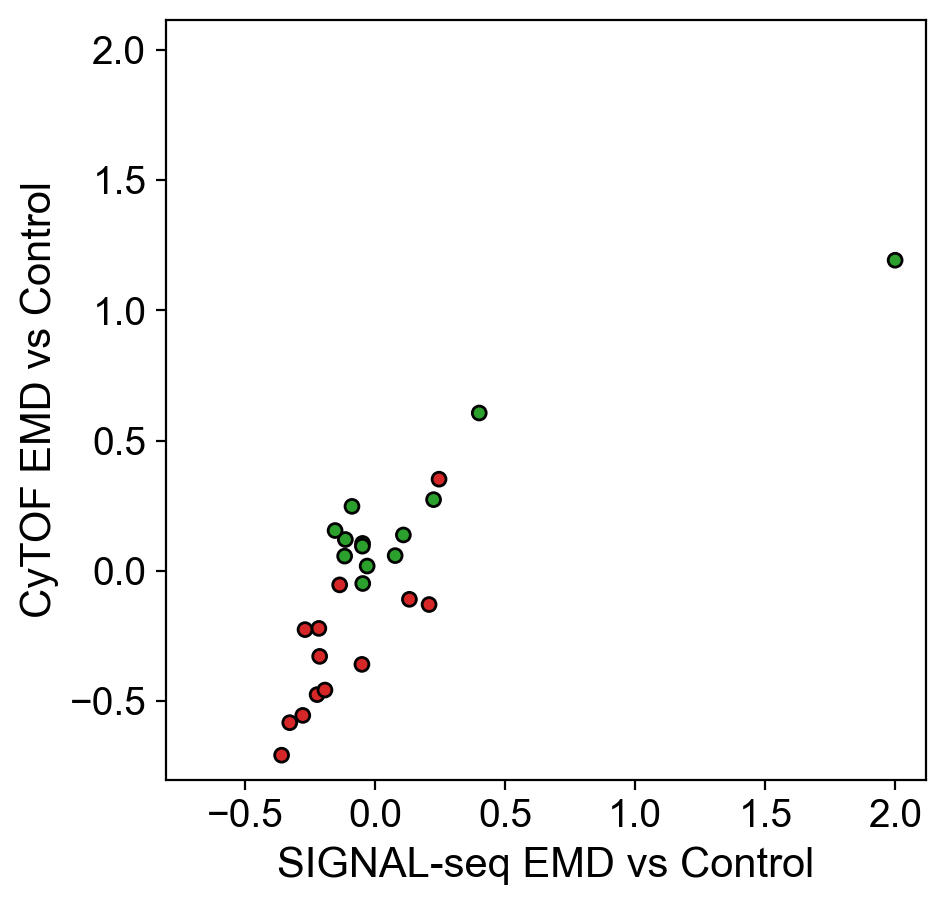

In [13]:
# plotting Colours
colors = {'Growth Factors':'tab:green', 'Inhibitors':'tab:red'}

fig, ax = plt.subplots()
ax.scatter(merged_df['ADT'], merged_df['CYTOF'], s=25, c=merged_df['condition'].map(colors), zorder=10, edgecolor='black')

lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  
    np.max([ax.get_xlim(), ax.get_ylim()]), 
]

# Hide grid lines
ax.grid(False)

# Relable aspects
ax.set_aspect('equal')

# Adjust limits
ax.set_xlim(lims)
ax.set_ylim(lims)

# Axis labels
plt.xlabel('SIGNAL-seq EMD vs Control', fontsize=15)
plt.ylabel('CyTOF EMD vs Control', fontsize=15)

# Save figure
fig.savefig('figure_1/adt_vs_mc_emds_all.pdf', dpi=300)

In [14]:
# Subset
ptm_id_map = ['sample_id',
    'cCaspase_3_[D175]_v2', 'pMKK4/SEK1_[S257]', 'p4E-BP1_[T37/46]_v2',
    'pP38_MAPK_[T180/Y182]_v2', 'pS6_[S240/S244]_2', 'pNDRG1_[T346]'
 ]

# Run the EMD based on GF/STIM
adt_emd_stim = calculate_emd(emd_data=protein_data_clr_df_ptm[ptm_id_map], control_obs='sample_id', control_condition="GFs MEKi PI3Ki")

adt_emd_stim_hmap = adt_emd_stim.iloc[:, 0:2]

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_21290/306477554.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = mpl.cm.get_cmap('coolwarm')


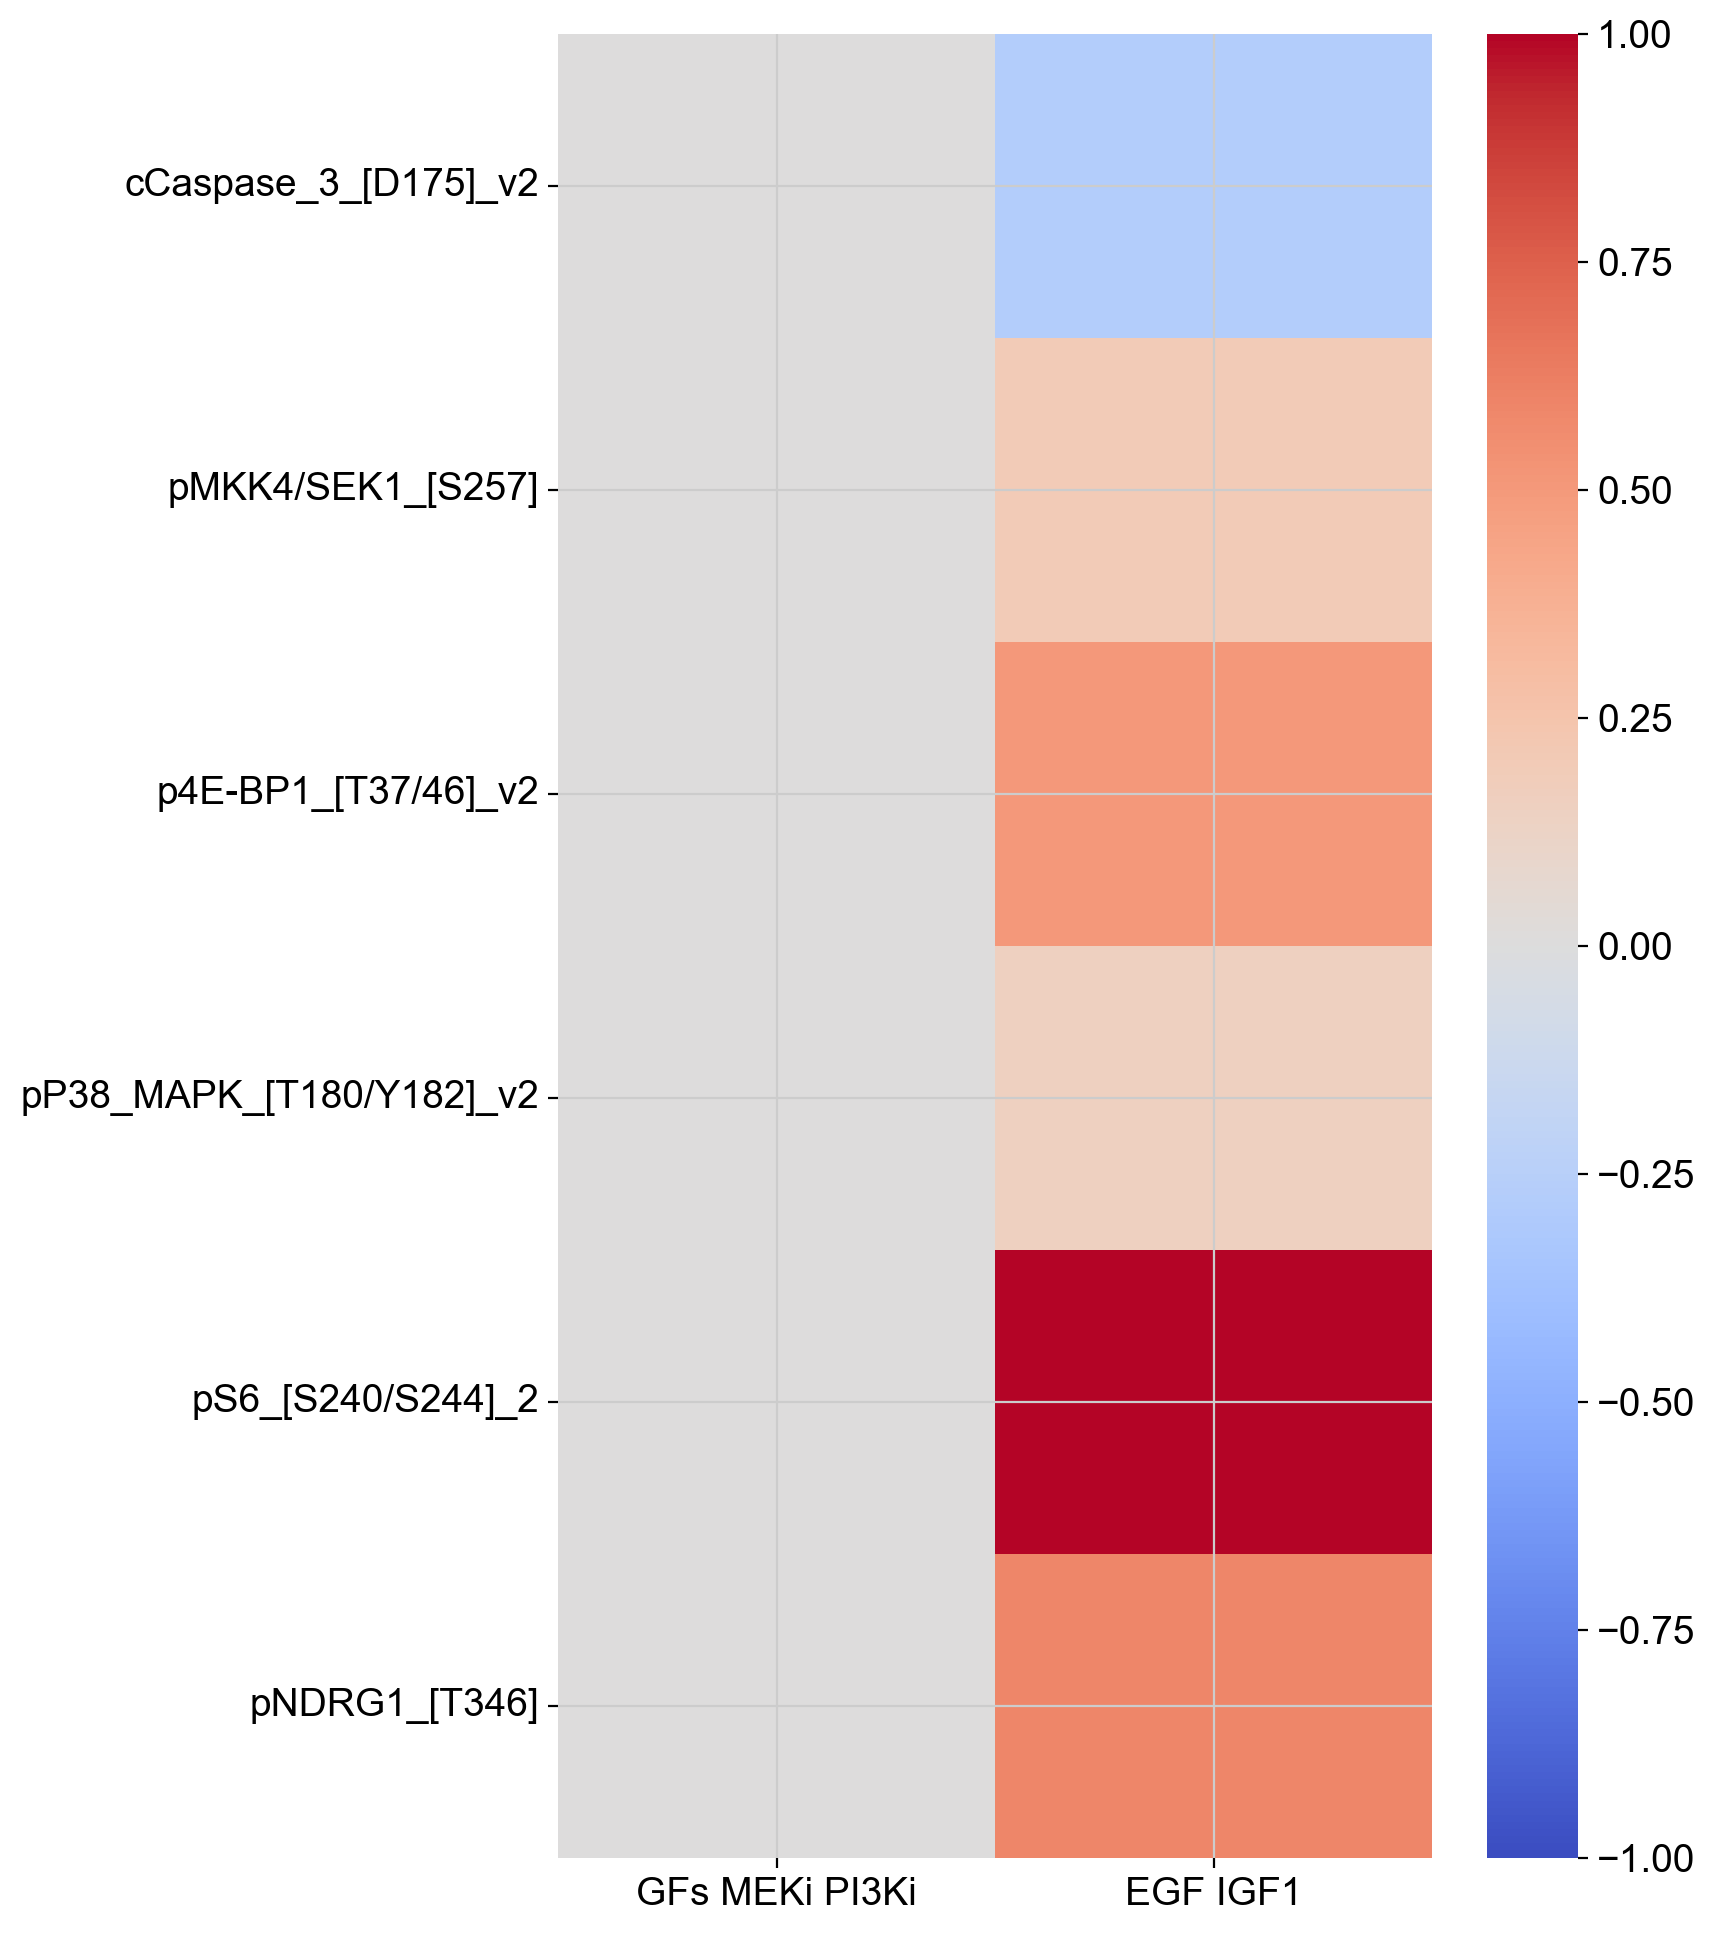

In [15]:
# Plot heatmap
fig, ax = plt.subplots(figsize=(7, 12))
colormap = mpl.cm.get_cmap('coolwarm')
offset = mcolors.TwoSlopeNorm(vcenter=-0, vmin = -1, vmax = 1)
sns.heatmap(adt_emd_stim_hmap, cmap=colormap,norm=offset)
plt.savefig('figure_1/emd_adt_stim_vs_inhib.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()

In [16]:
# Run the EMD based on GF/STIM
adt_emd_ihib = calculate_emd(emd_data=protein_data_clr_df_ptm[ptm_id_map], control_obs='sample_id', control_condition="EGF IGF1")

adt_emd_ihib = adt_emd_ihib.iloc[:, 0:2]

/var/folders/rk/05jx38f57w75573dgxbjlrm40000gn/T/ipykernel_21290/3455990614.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colormap = mpl.cm.get_cmap('coolwarm')


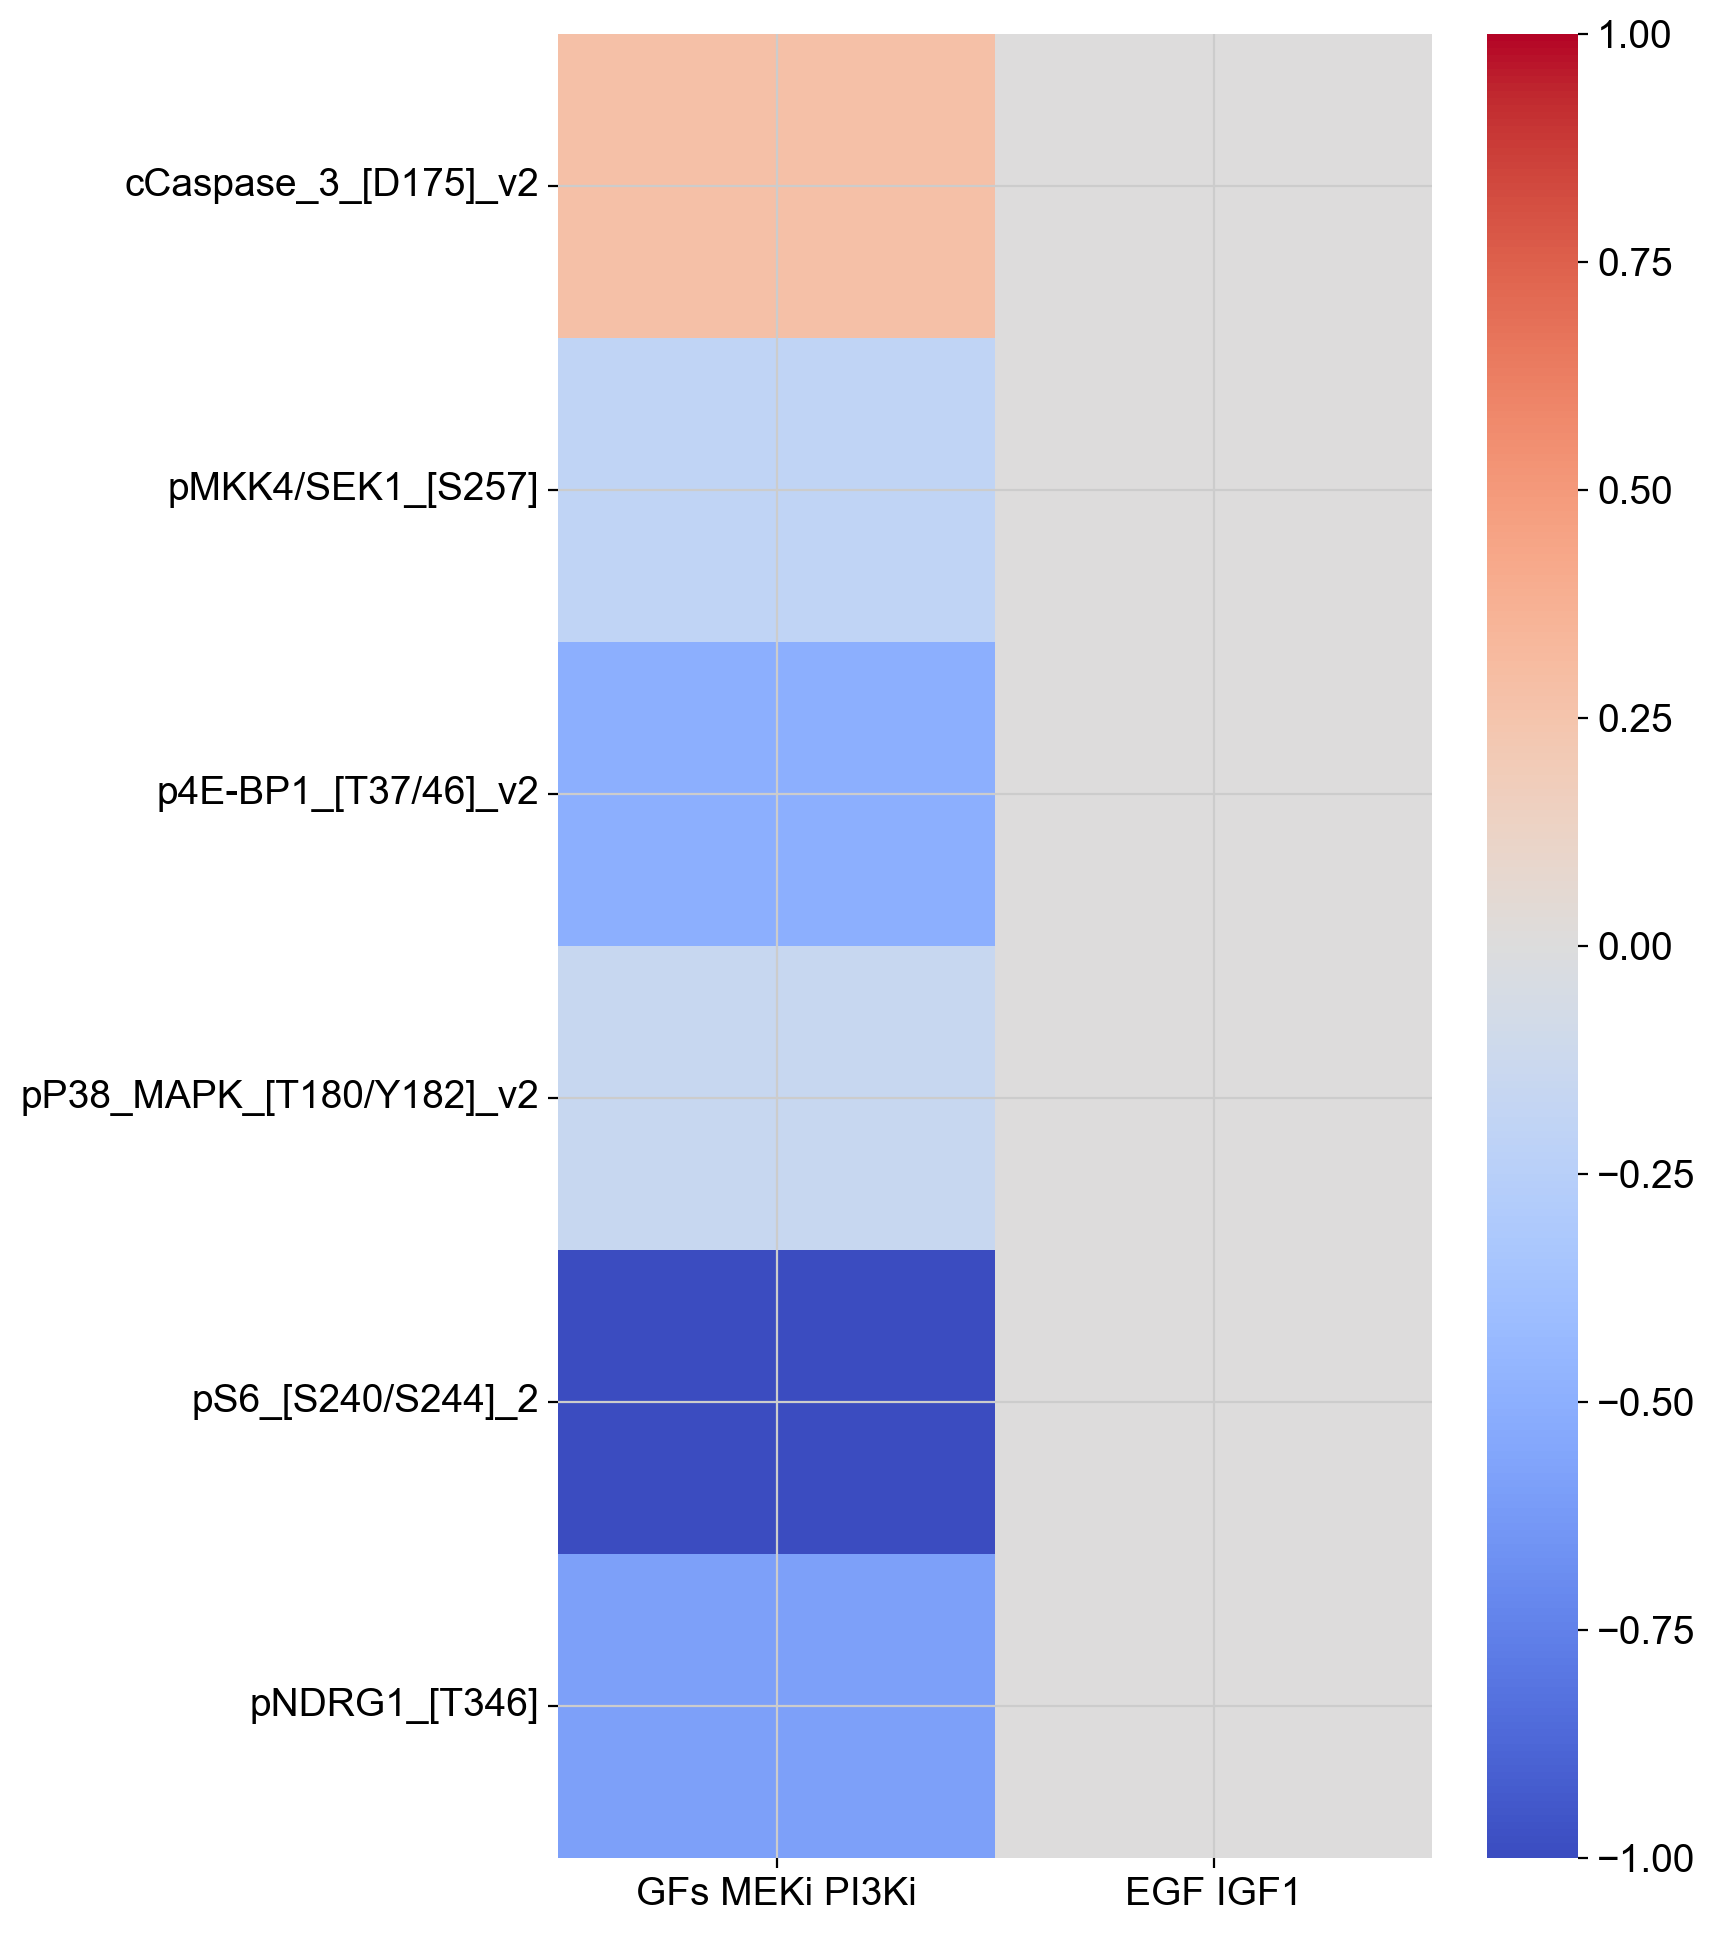

In [17]:
fig, ax = plt.subplots(figsize=(7, 12))
colormap = mpl.cm.get_cmap('coolwarm')
offset = mcolors.TwoSlopeNorm(vcenter=-0, vmin = -1, vmax = 1)
sns.heatmap(adt_emd_ihib, cmap=colormap,norm=offset)
plt.savefig('figure_1/emd_adt_inhib_vs_stim.pdf', dpi=600, transparent=True, bbox_inches='tight')
plt.show()